In [65]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.contrib import learn

In [7]:
# fix random seed for reproducibility
np.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('data/international-airline-passengers.csv',sep=";", usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

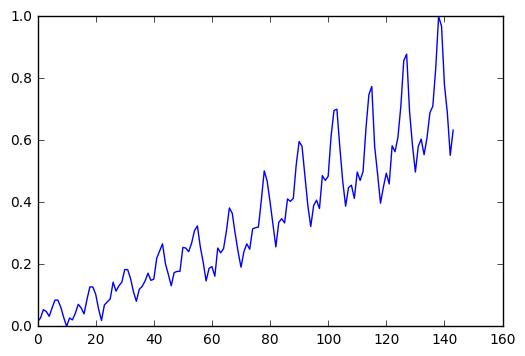

In [9]:
plt.plot(dataset)
plt.show()

In [25]:
def lstm_model(time_steps, rnn_layers, dense_layers=None):
    """
    Creates a deep model based on:
        * stacked lstm cells
        * an optional dense layers
    :param time_steps: the number of time steps the model will be looking at.
    :param rnn_layers: list of int or dict
                         * list of int: the steps used to instantiate the `BasicLSTMCell` cell
                         * list of dict: [{steps: int, keep_prob: int}, ...]
    :param dense_layers: list of nodes for each layer
    :return: the model definition
    """

    def lstm_cells(layers):
        if isinstance(layers[0], dict):
            return [tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                               state_is_tuple=True),
                                                  layer['keep_prob'])
                    if layer.get('keep_prob') else tf.nn.rnn_cell.BasicLSTMCell(layer['steps'],
                                                                                state_is_tuple=True)
                    for layer in layers]
        return [tf.nn.rnn_cell.BasicLSTMCell(steps, state_is_tuple=True) for steps in layers]

    def dnn_layers(input_layers, layers):
        if layers and isinstance(layers, dict):
            return learn.ops.dnn(input_layers,
                                 layers['layers'],
                                 activation=layers.get('activation'),
                                 dropout=layers.get('dropout'))
        elif layers:
            return learn.ops.dnn(input_layers, layers)
        else:
            return input_layers

    def _lstm_model(X, y):
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = learn.ops.split_squeeze(1, time_steps, X)
        output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=dtypes.float32)
        output = dnn_layers(output[-1], dense_layers)
        return learn.models.linear_regression(output, y)

    return _lstm_model

In [35]:
def generate_data(fct, x, time_steps, seperate=False):
    """generates data with based on a function fct"""
    data = fct(x)
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    train_x, val_x, test_x = prepare_data(data['a'] if seperate else data, time_steps)
    train_y, val_y, test_y = prepare_data(data['b'] if seperate else data, time_steps, labels=True)
    return dict(train=train_x, val=val_x, test=test_x), dict(train=train_y, val=val_y, test=test_y)

def prepare_data(data, time_steps, labels=False, val_size=0.05, test_size=0.05):
    """
    Given the number of `time_steps` and some data,
    prepares training, validation and test data for an lstm cell.
    """
    df_train, df_val, df_test = split_data(data, val_size, test_size)
    return (rnn_data(df_train, time_steps, labels=labels),
            rnn_data(df_val, time_steps, labels=labels),
            rnn_data(df_test, time_steps, labels=labels))

In [27]:
def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]

    return df_train, df_val, df_test

In [37]:
def rnn_data(data, time_steps, labels=False):
    rnn_df = []
    for i in range(len(data)- time_steps):
        if labels:
            try: 
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    return np.array(rnn_df)

In [50]:
LOG_dir = './ops_logs'
TIMESTEPS = 5
RNN_LAYERS = [{'steps': TIMESTEPS}]
DENSE_LAYERS = [10, 10]
TRAINING_STEPS = 100000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100
NUM_UNITS = 40

In [38]:
X, y = generate_data(np.sin, np.linspace(0, 100, 10000), TIMESTEPS, seperate=False)

In [67]:
regressor = tf.contrib.learn.TensorFlowEstimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS), 
                                                 n_classes = 0, 
                                                 verbose = 1, 
                                                 steps = TRAINING_STEPS, 
                                                 optimizer = 'Adagrad', 
                                                 learning_rate = 0.03, 
                                                 batch_size = BATCH_SIZE)

In [68]:
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                      every_n_steps=PRINT_STEPS,
                                                      early_stopping_rounds=1000)

In [70]:
regressor.fit(X['train'], y['train'], monitors=[validation_monitor], logdir=LOG_dir)

AttributeError: 'module' object has no attribute 'split_squeeze'

In [ ]:
predicted = regressor.predict(X['test'])
mse = mean_squared_error(y['test'], predicted)